In [1]:
"""DNNRegressor with custom input_fn for Housing dataset."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import itertools

import pandas as pd
import tensorflow as tf
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
tf.logging.set_verbosity(tf.logging.INFO)

COLUMNS = ["DEPTH","DT","GR","LLD","LLS","PHIE","PHIT","RHOB","SW","TNPH","VWCL"]
FEATURES = ["DEPTH","DT","GR","LLD","LLS","RHOB","TNPH"]
LABELS = ["phit","phie","sw"]
LABEL = "vwcl"

# COLUMNS = ["crim", "zn", "indus", "nox", "rm", "age",
#            "dis", "tax", "ptratio", "medv"]
# FEATURES = ["crim", "zn", "indus", "nox", "rm",
#             "age", "dis", "tax", "ptratio"]
# LABEL = "medv"

def get_input_fn(data_set, num_epochs=None, shuffle=True):
  return tf.estimator.inputs.pandas_input_fn(
      x=pd.DataFrame({k: data_set[k].values for k in FEATURES}),
      y=pd.Series(data_set[LABEL].values) ,
#       y=pd.DataFrame({k: data_set[k].values for k in LABELS[0:3]}),
#       y = pd.DataFrame({k: data_set[k].values  for k in LABELS},index=data_set.index),
      batch_size=1,
      num_epochs=num_epochs,
      shuffle=False)
COLUMNS=[c.lower() for c in COLUMNS]
FEATURES=[c.lower() for c in FEATURES]
# COLUMNS
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
# folder=r'D:\Ameyem Office\Geoservices\Neeraj & me\log data\\'
# df=pd.read_csv('lasdata.csv')
df=pd.read_csv('lasdata.csv',skipinitialspace=True, \
                         skiprows=1, names=COLUMNS)

folder="D:\SoftwareWebApps\Python\GeoProjects\AI&ML\\"
# training_set = pd.read_csv(folder+"lasdata.csv", skipinitialspace=True,
#                          skiprows=1, names=COLUMNS)
# test_set = pd.read_csv(folder+"lasdata-test.csv", skipinitialspace=True,
#                      skiprows=1, names=COLUMNS)
# # Set of 6 examples for which to predict median house values
prediction_set_or = pd.read_csv(folder+"lasdata-predict.csv",skipinitialspace=True, \
                         skiprows=1, names=COLUMNS)
# prediction_set
# df.head()

In [2]:
def transform(scaler,target_df):
    return pd.DataFrame(scaler_x.transform(target_df.values),columns=target_df.columns)
scaler_x = StandardScaler()
# Fit only to the training data
training_set = df.iloc[0:-100]
scaler_x.fit(training_set.values)

training_set=transform(scaler_x,df.iloc[:-600])
test_set = transform(scaler_x,df.iloc[-600:])
prediction_set= transform(scaler_x,prediction_set_or)
training_set,prediction_set

scaler_y = StandardScaler()
scaler_y.fit(df[LABEL].iloc[0:-100].values.reshape(-1, 1))
Y_train=scaler_y.transform(prediction_set_or[LABEL].values.reshape(-1, 1))
# prediction_set[LABEL].values,Y_train.reshape(1,-1 )


In [3]:
# Feature cols
feature_cols = [tf.feature_column.numeric_column(k) for k in FEATURES]
hid_units=[1024, 512,256 ]
# Build 2 layer fully connected DNN with 10, 10 units respectively.
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols,
                                    hidden_units=hid_units,
                                      optimizer=tf.train.ProximalAdagradOptimizer(
                                      learning_rate=0.01,
                                      l1_regularization_strength=0.001
                                    ),
                                    model_dir="/tmp/allvwcl1024_d_model")

# Train
regressor.train(input_fn=get_input_fn(training_set), steps=50000)

# Evaluate loss over one epoch of test_set.
ev = regressor.evaluate(
  input_fn=get_input_fn(test_set, num_epochs=1, shuffle=True))
loss_score = ev["loss"]
print("Loss: {0:f}".format(loss_score))

# Print out predictions over a slice of prediction_set.
y = regressor.predict(
  input_fn=get_input_fn(prediction_set, num_epochs=1, shuffle=True))
# .predict() returns an iterator of dicts; convert to a list and print
# predictions
predictions = list(p["predictions"] for p in itertools.islice(y, len(prediction_set)))
# print("Predictions: {}".format(str(predictions)))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/allvwcl1024_d_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000013DAB3CB9E8>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/allvwcl1024_d_model\model.ckpt.
INFO:tensorflow:loss = 1.8732135, step = 1
INFO:tensorflow:global_step/sec: 51.862
INFO:tensorflow:loss = 0.004516886, step = 101 (1.912 sec)
INFO:tensorflow:global_step/sec: 71.6682
INFO:tensorflow:loss = 0.0033882498, step = 201 (1.391 sec)
INFO:tensorflow:global_step/sec: 55.166

INFO:tensorflow:global_step/sec: 45.9013
INFO:tensorflow:loss = 0.054805845, step = 7501 (2.180 sec)
INFO:tensorflow:global_step/sec: 51.1136
INFO:tensorflow:loss = 0.0493923, step = 7601 (1.954 sec)
INFO:tensorflow:global_step/sec: 59.4135
INFO:tensorflow:loss = 0.7617938, step = 7701 (1.683 sec)
INFO:tensorflow:global_step/sec: 60.1461
INFO:tensorflow:loss = 6.3783006e-07, step = 7801 (1.662 sec)
INFO:tensorflow:global_step/sec: 53.8642
INFO:tensorflow:loss = 0.01975363, step = 7901 (1.858 sec)
INFO:tensorflow:global_step/sec: 51.3131
INFO:tensorflow:loss = 0.0018774023, step = 8001 (1.953 sec)
INFO:tensorflow:global_step/sec: 57.4175
INFO:tensorflow:loss = 0.021452416, step = 8101 (1.737 sec)
INFO:tensorflow:global_step/sec: 52.17
INFO:tensorflow:loss = 0.012750735, step = 8201 (1.919 sec)
INFO:tensorflow:global_step/sec: 44.4861
INFO:tensorflow:loss = 0.0012653285, step = 8301 (2.250 sec)
INFO:tensorflow:global_step/sec: 46.2812
INFO:tensorflow:loss = 0.2283433, step = 8401 (2.156 

INFO:tensorflow:global_step/sec: 53.2437
INFO:tensorflow:loss = 0.045203023, step = 15601 (1.882 sec)
INFO:tensorflow:global_step/sec: 47.5506
INFO:tensorflow:loss = 0.023609838, step = 15701 (2.103 sec)
INFO:tensorflow:global_step/sec: 56.6551
INFO:tensorflow:loss = 0.053688895, step = 15801 (1.760 sec)
INFO:tensorflow:global_step/sec: 49.7144
INFO:tensorflow:loss = 1.5171599, step = 15901 (2.010 sec)
INFO:tensorflow:global_step/sec: 50.2418
INFO:tensorflow:loss = 0.050509293, step = 16001 (1.997 sec)
INFO:tensorflow:global_step/sec: 50.4897
INFO:tensorflow:loss = 0.09732379, step = 16101 (1.975 sec)
INFO:tensorflow:global_step/sec: 44.1839
INFO:tensorflow:loss = 0.42852592, step = 16201 (2.271 sec)
INFO:tensorflow:global_step/sec: 51.4707
INFO:tensorflow:loss = 0.0021392184, step = 16301 (1.937 sec)
INFO:tensorflow:global_step/sec: 60.6669
INFO:tensorflow:loss = 0.011881063, step = 16401 (1.650 sec)
INFO:tensorflow:global_step/sec: 49.7153
INFO:tensorflow:loss = 0.0015901036, step = 

INFO:tensorflow:global_step/sec: 50.1856
INFO:tensorflow:loss = 0.030492041, step = 23701 (1.987 sec)
INFO:tensorflow:global_step/sec: 50.7773
INFO:tensorflow:loss = 0.08934685, step = 23801 (1.967 sec)
INFO:tensorflow:global_step/sec: 48.0017
INFO:tensorflow:loss = 0.018205386, step = 23901 (2.084 sec)
INFO:tensorflow:global_step/sec: 71.2551
INFO:tensorflow:loss = 0.0008465013, step = 24001 (1.402 sec)
INFO:tensorflow:global_step/sec: 54.784
INFO:tensorflow:loss = 0.00084931654, step = 24101 (1.826 sec)
INFO:tensorflow:global_step/sec: 47.252
INFO:tensorflow:loss = 0.026228959, step = 24201 (2.125 sec)
INFO:tensorflow:global_step/sec: 48.7471
INFO:tensorflow:loss = 0.0061356043, step = 24301 (2.042 sec)
INFO:tensorflow:global_step/sec: 54.1555
INFO:tensorflow:loss = 0.08583533, step = 24401 (1.855 sec)
INFO:tensorflow:global_step/sec: 45.2855
INFO:tensorflow:loss = 0.014821291, step = 24501 (2.200 sec)
INFO:tensorflow:global_step/sec: 55.8291
INFO:tensorflow:loss = 0.0025696207, step

INFO:tensorflow:global_step/sec: 36.9433
INFO:tensorflow:loss = 0.0077417865, step = 31701 (2.708 sec)
INFO:tensorflow:global_step/sec: 49.0259
INFO:tensorflow:loss = 0.02591421, step = 31801 (2.041 sec)
INFO:tensorflow:global_step/sec: 48.0939
INFO:tensorflow:loss = 0.00839169, step = 31901 (2.079 sec)
INFO:tensorflow:global_step/sec: 49.6658
INFO:tensorflow:loss = 0.0067928685, step = 32001 (2.014 sec)
INFO:tensorflow:global_step/sec: 54.2187
INFO:tensorflow:loss = 0.034080416, step = 32101 (1.846 sec)
INFO:tensorflow:global_step/sec: 59.5393
INFO:tensorflow:loss = 0.3232274, step = 32201 (1.675 sec)
INFO:tensorflow:global_step/sec: 76.129
INFO:tensorflow:loss = 0.030627215, step = 32301 (1.314 sec)
INFO:tensorflow:global_step/sec: 59.1313
INFO:tensorflow:loss = 0.03808589, step = 32401 (1.692 sec)
INFO:tensorflow:global_step/sec: 75.0334
INFO:tensorflow:loss = 0.006369554, step = 32501 (1.332 sec)
INFO:tensorflow:global_step/sec: 60.6472
INFO:tensorflow:loss = 0.019439392, step = 32

INFO:tensorflow:global_step/sec: 43.6751
INFO:tensorflow:loss = 0.0004221046, step = 39801 (2.277 sec)
INFO:tensorflow:global_step/sec: 49.592
INFO:tensorflow:loss = 0.054332636, step = 39901 (2.015 sec)
INFO:tensorflow:global_step/sec: 50.9777
INFO:tensorflow:loss = 0.00049088174, step = 40001 (1.968 sec)
INFO:tensorflow:global_step/sec: 61.1862
INFO:tensorflow:loss = 0.005612801, step = 40101 (1.628 sec)
INFO:tensorflow:global_step/sec: 56.7808
INFO:tensorflow:loss = 0.05750633, step = 40201 (1.763 sec)
INFO:tensorflow:global_step/sec: 47.5434
INFO:tensorflow:loss = 0.013009001, step = 40301 (2.103 sec)
INFO:tensorflow:global_step/sec: 42.9349
INFO:tensorflow:loss = 0.0008581951, step = 40401 (2.330 sec)
INFO:tensorflow:global_step/sec: 51.4503
INFO:tensorflow:loss = 0.04061719, step = 40501 (1.945 sec)
INFO:tensorflow:global_step/sec: 52.0923
INFO:tensorflow:loss = 0.015434529, step = 40601 (1.920 sec)
INFO:tensorflow:global_step/sec: 57.1984
INFO:tensorflow:loss = 4.676107, step = 

INFO:tensorflow:global_step/sec: 68.2135
INFO:tensorflow:loss = 0.089619055, step = 47901 (1.465 sec)
INFO:tensorflow:global_step/sec: 58.8169
INFO:tensorflow:loss = 0.056682758, step = 48001 (1.706 sec)
INFO:tensorflow:global_step/sec: 84.9149
INFO:tensorflow:loss = 0.027354369, step = 48101 (1.173 sec)
INFO:tensorflow:global_step/sec: 90.3698
INFO:tensorflow:loss = 0.012569505, step = 48201 (1.107 sec)
INFO:tensorflow:global_step/sec: 90.8049
INFO:tensorflow:loss = 0.007356229, step = 48301 (1.099 sec)
INFO:tensorflow:global_step/sec: 84.3941
INFO:tensorflow:loss = 0.019712593, step = 48401 (1.187 sec)
INFO:tensorflow:global_step/sec: 66.3659
INFO:tensorflow:loss = 0.05655702, step = 48501 (1.507 sec)
INFO:tensorflow:global_step/sec: 56.245
INFO:tensorflow:loss = 0.34583694, step = 48601 (1.777 sec)
INFO:tensorflow:global_step/sec: 89.4055
INFO:tensorflow:loss = 0.0047935303, step = 48701 (1.118 sec)
INFO:tensorflow:global_step/sec: 71.2874
INFO:tensorflow:loss = 0.09456476, step = 4

In [4]:
regressor.model_dir
# content
with open(regressor.model_dir+'/checkpoint','r') as fo:
    content = fo.readline()
content = content.strip()
content

'model_checkpoint_path: "model.ckpt-50000"'

In [5]:
# regressor.model_dir
# regressor.get_variable_value('model_checkpoint_path')
# int(content[0])
Y_train=prediction_set[LABEL].values
Y_pred=np.array([p[0] for p in predictions])
Y_train_inv=scaler_y.inverse_transform(Y_train)
Y_pred_inv=scaler_y.inverse_transform(Y_pred)
# prediction_set_or[LABEL].values,
# Y_train,Y_pred=Y_train_inv,Y_pred_inv
Y_train_inv,Y_pred_inv
# fo=open('/tmp/allphit1024_model/checkpoint','r')
with open(regressor.model_dir+'/checkpoint','r') as fo:
    content = fo.readline()
content = content.strip()
imname=regressor.model_dir.split('/')[-1]+'_'+content.replace('"','').replace('model_checkpoint_path: model.ckpt-','')

hid_info=str(hid_units).replace(', ','_').replace('[','').replace(']','')
imname='withdepth-'+imname+'_nodes_'+hid_info
# fo.close()
imname

'withdepth-allvwcl1024_d_model_50000_nodes_1024_512_256'

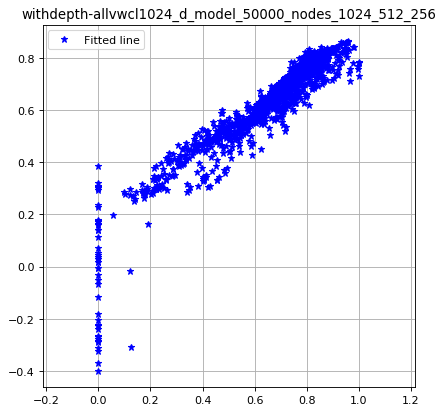

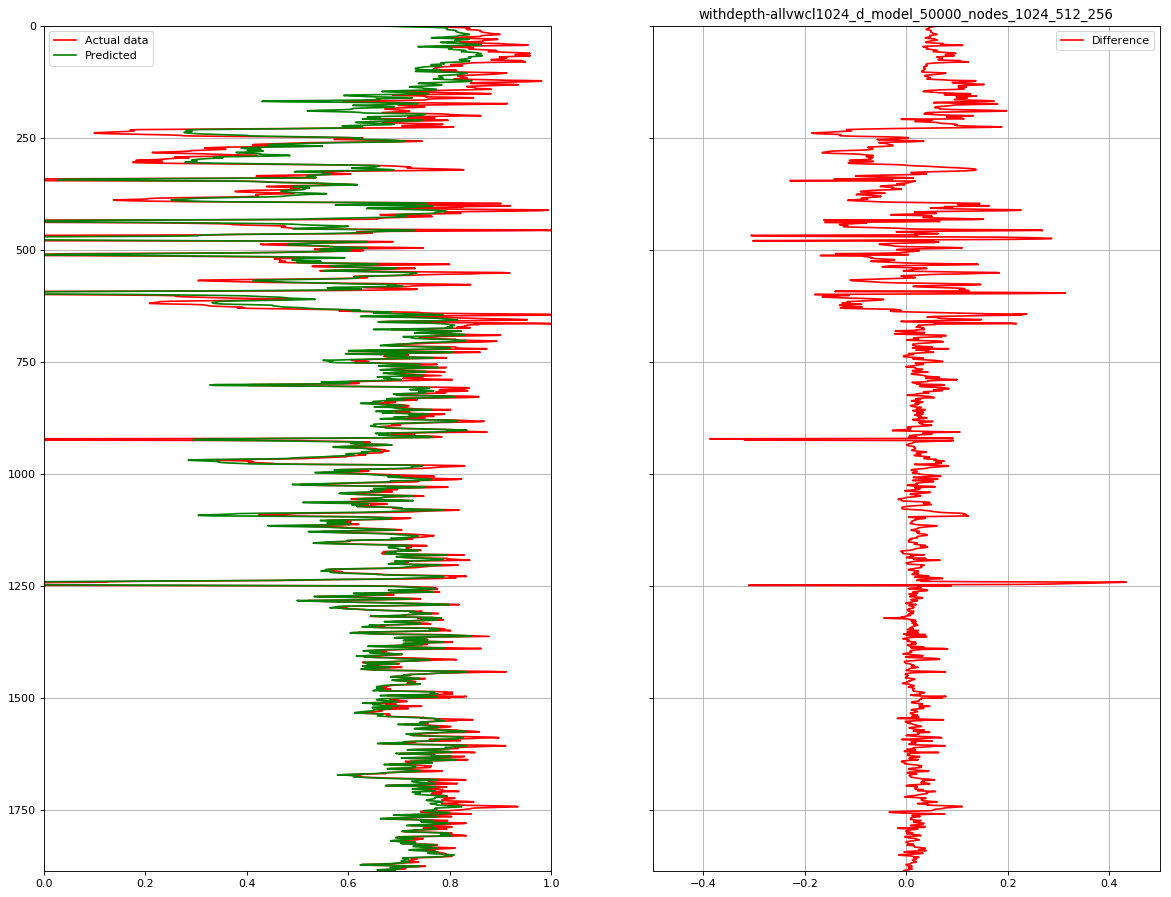

In [7]:
fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), dpi= 80, sharey=True)
# with ax_ as ax1:
ax1.plot(Y_train_inv, Y_pred_inv,'b*', label='Fitted line')
ax1.legend()
ax1.axis('equal')
ax1.grid(True)
plt.title(imname)
plt.show() #5000 epochs, 1024

fig1.savefig(imname+'_scatter.png', dpi=100)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 14), dpi= 80, sharey=True)
i=0
perc_diff=(-Y_pred_inv+Y_train_inv)
for axes in ax:
    if(i==0):
        axes.plot( Y_train_inv,range(len(Y_train)), label="Actual data",color='red')
        axes.plot( Y_pred_inv,range(len(Y_pred)), label="Predicted",color='green')
        axes.set_xlim (min(Y_train_inv),max(Y_train_inv))
    else:
        axes.plot(perc_diff  ,range(len(perc_diff)), label="Difference",color='red')
        axes.set_xlim (-.5,+.5)
        axes.xaxis.grid(True)
#         axes.plot( Y_pred,range(len(Y_pred)), label="Predicted",color='green')
    i+=1
    axes.set_ylim (0,len(Y_train_inv))
    axes.legend()
    axes.invert_yaxis()
    axes.yaxis.grid(True)
plt.title(imname)
plt.show()  #5000 epochs, 1024
fig.savefig(imname+'_log.png', dpi=100)

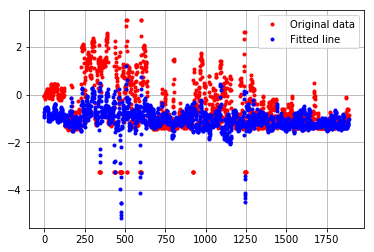

In [217]:
# %matplotlib inline
# from matplotlib import pyplot as plt
# Y_train=prediction_set[LABEL].values
# Y_pred=np.array([p[0] for p in predictions])
#     #Graphic display
plt.plot(range(len(Y_train)), Y_train, 'r.', label='Original data')
plt.plot(range(len(Y_train)), Y_pred,'b.', label='Fitted line')
# plt.plot(Y_train, Y_pred,'b*', label='Fitted line')
plt.legend()
# plt.axis([-2, 3, -2, 3])
# plt.axis('equal')
plt.grid(True)
plt.show()

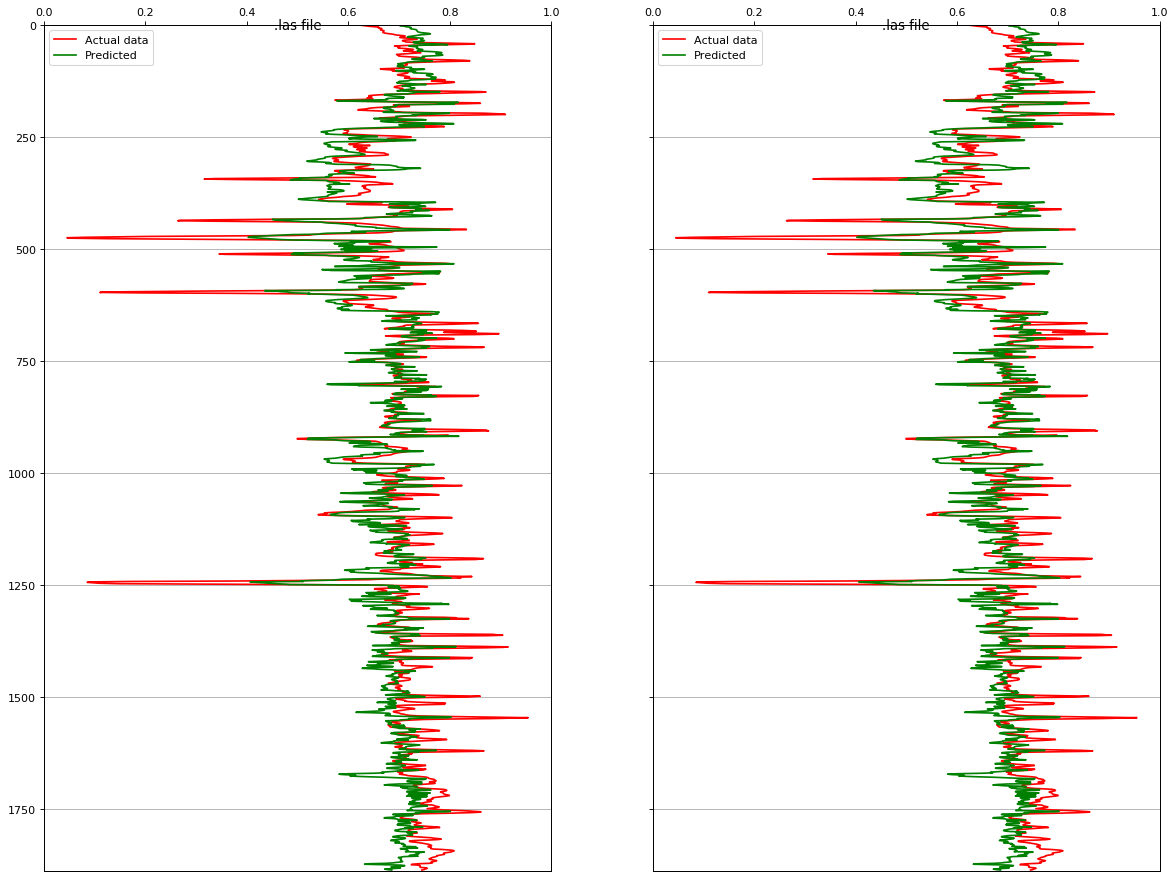

In [109]:
%matplotlib inline
from matplotlib import pyplot as plt
# Y_train,Y_pred
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 14), dpi= 80, sharey=True)
for axes in ax:
    axes.plot( Y_train,range(len(Y_train)), label="Actual data",color='red')
    axes.plot( Y_pred,range(len(Y_pred)), label="Predicted",color='green')
    axes.set_ylim (0,len(Y_train))
    axes.legend()
    axes.invert_yaxis()
    axes.yaxis.grid(True)
    axes.get_xaxis().set_visible(False) 
    axes.set_title('.las file',verticalalignment='top')
    axes.spines['top'].set_position(('outward',0))
    axes.set_xlabel("hi")
    axes.twiny()
    
    
plt.show()


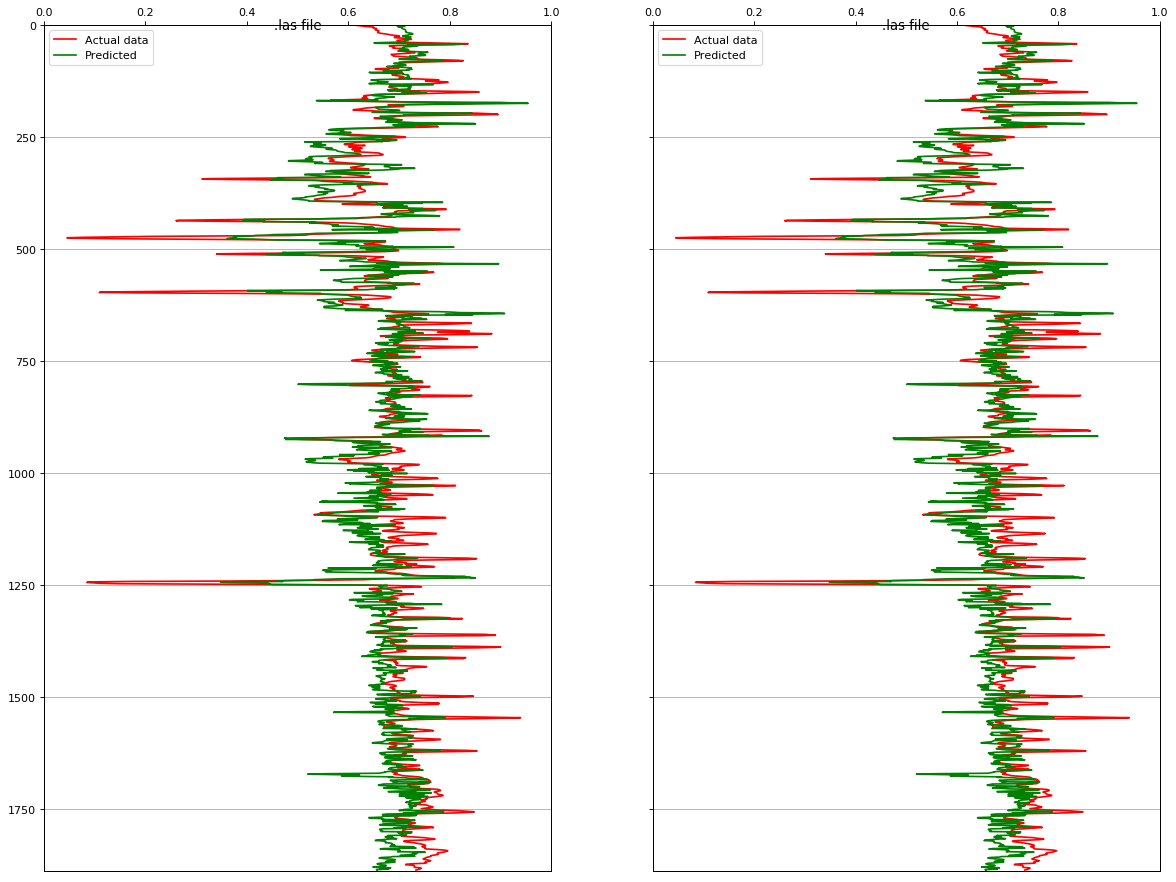

In [111]:
Y_train=prediction_set[LABEL].values
Y_pred=np.array([p[0] for p in predictions])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 14), dpi= 80, sharey=True)
for axes in ax:
    axes.plot( Y_train,range(len(Y_train)), label="Actual data",color='red')
    axes.plot( Y_pred,range(len(Y_pred)), label="Predicted",color='green')
    axes.set_ylim (0,len(Y_train))
    axes.legend()
    axes.invert_yaxis()
    axes.yaxis.grid(True)
    axes.get_xaxis().set_visible(False) 
    axes.set_title('.las file',verticalalignment='top')
    axes.spines['top'].set_position(('outward',0))
    axes.set_xlabel("hi")
    axes.twiny()
    
    
plt.show()